In [99]:
from transformers import BertConfig, BertModel, BertLMHeadModel, BartConfig,BartModel, BartForCausalLM, GPT2Config, GPT2Model, AutoModelForCausalLM, GPT2LMHeadModel
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TestModel(nn.Module):
    def __init__(self, vocab_size=140):
        super(TestModel, self).__init__()
        self.configuration = GPT2Config(vocab_size=vocab_size, bos_token_id=2, eos_token_id=1)
        self.model = GPT2LMHeadModel(self.configuration)
        
        self.optimizer = optimizer = AdamW(self.model.parameters(), lr=3e-5)
        self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.97 ** epoch)
    
    def forward(self, input_ids, labels=None):
        attention_mask = self.make_mask(input_ids)
        output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return output
    
    def make_mask(self, input_ids):
        attention_mask = (input_ids != 0).long()
        return attention_mask
    
    def infer(self, input_ids, length=2048):
        if len(input_ids.shape) == 1:
            input_ids = input_ids.unsqueeze(0)
        if len(input_ids.shape) > 2:
            raise Exception
        
        if length > 2048:
            print("Max Length is 2048. Change Length Auto to 2048")
            length = 2048
        
        with torch.no_grad():
            for step in range(length):
                output = self.forward(input_ids)
                output = torch.argmax(output.logits, dim=2)

                predict = output[:,-1].unsqueeze(1)
                output_ids = torch.cat((input_ids, predict), dim=-1)

                input_ids = output_ids
                
                # if torch.all(predict.eq(0)):
                #     break
                
                if output_ids.shape[1] > 2048:
                    break

        return output_ids
    
model = TestModel(vocab_size=30)

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
t = model(input_ids=test, labels=test)
print(t.keys())

In [41]:
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

inputs = tokenizer(["Hello, my dog is cute", "Hello"], return_tensors="pt", padding=True, truncation=True)

print(inputs)

{'input_ids': tensor([[15496,    11,   616,  3290,   318, 13779],
        [15496, 50257, 50257, 50257, 50257, 50257]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0]])}


In [104]:
from tqdm import tqdm
criterion = nn.CrossEntropyLoss()

loss_list = []
model.train()
for i in tqdm(range(500)):
    input_ids = torch.tensor([[2,3,6,9,12,15,18,21,1],[2,3,9,3,9,3,1,0,0]])
    # attention_mask = torch.tensor([[1,1,1,1,1,1,1,1,1],[1,1,1,1,1,0,0,0,0]])
    out = model(input_ids=input_ids, labels=input_ids)
    
    # loss = criterion(out.logits.view(-1, 30), targets.view(-1))
    loss = out.loss
    print(loss)
    if i % 10 == 0:
        print(torch.argmax(out.logits, dim=2))
    loss.backward()
    loss_list.append(loss.item())
    model.optimizer.step()
    model.scheduler.step()


  0%|          | 0/500 [00:00<?, ?it/s]

tensor(0.1571, grad_fn=<NllLossBackward0>)
tensor([[ 3,  9,  9, 12, 15, 18, 21,  1,  0],
        [ 3,  9,  3,  9,  3,  1,  0,  0,  0]])


  0%|          | 1/500 [00:02<22:24,  2.69s/it]


KeyboardInterrupt: 

In [91]:
print(input_ids[:,:-6])
out = model(input_ids=input_ids[:,:-6])
print(out.keys())
# print(out.loss)
print(out.logits.shape)
print(torch.argmax(out.logits, dim=2))

tensor([[2, 3, 6],
        [2, 3, 9]])
odict_keys(['logits', 'past_key_values'])
torch.Size([2, 3, 30])
tensor([[3, 6, 9],
        [3, 6, 3]])


In [102]:
print(input_ids[:,:2])
inf = model.infer(input_ids[:,:2], length=6)
print(inf)

tensor([[2, 3],
        [2, 3]])
tensor([[2, 3, 9, 3, 9, 3, 1, 0],
        [2, 3, 9, 3, 9, 3, 1, 0]])


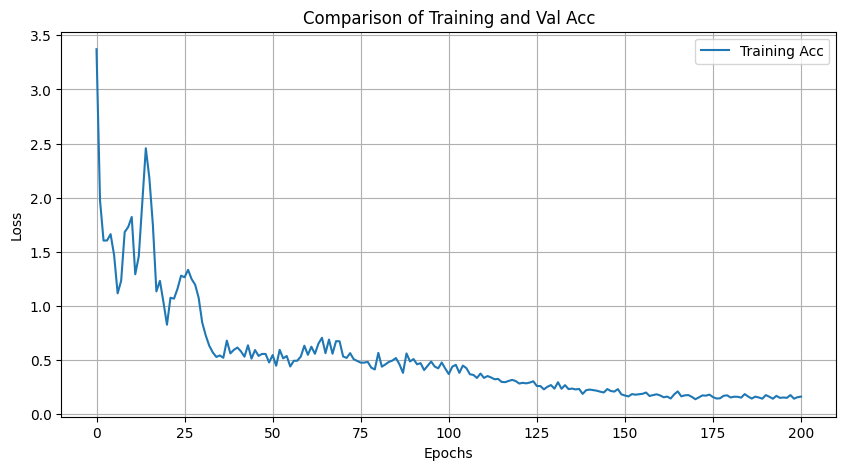

In [103]:
import pickle
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(loss_list, label='Training Acc')
plt.title('Comparison of Training and Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
print(loss)

tensor(20.6955, grad_fn=<NllLossBackward0>)


In [2]:
import torch
from transformers import AutoTokenizer, BartModel

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
model = BartModel.from_pretrained("facebook/bart-base")

inputs = tokenizer(["Hello, my dog is cute", "hi what is your name? hi what is your name? hi what is your name?"], return_tensors="pt", padding=True, truncation=True)
print(inputs)
print("=========================================================")
outputs = model(**inputs, labels=inputs["input_ids"])
print(outputs.keys())
print(outputs.logits.shape)
print(torch.argmax(outputs.logits, dim=2))
print("[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]")
outputs = model(**inputs)
print(outputs.keys())
print(outputs.loss)
print(outputs.logits.shape)
print(torch.argmax(outputs.logits, dim=2))
print("[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]")
outputs = model(input_ids=inputs['input_ids'])
print(outputs.keys())
print(outputs.loss)
print(outputs.logits.shape)
print(torch.argmax(outputs.logits, dim=2))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': tensor([[    0, 31414,     6,   127,  2335,    16, 11962,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    0,  3592,    99,    16,   110,   766,   116, 20280,    99,    16,
           110,   766,   116, 20280,    99,    16,   110,   766,   116,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


TypeError: BartModel.forward() got an unexpected keyword argument 'labels'

In [34]:
prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
next_sentence = "The sky is blue due to the shorter wavelength of blue light."
encoding = tokenizer(prompt, next_sentence, return_tensors="pt")
print(encoding)

{'input_ids': tensor([[  101,  1999,  3304,  1010, 10733,  2366,  1999,  5337, 10906,  1010,
          2107,  2004,  2012,  1037,  4825,  1010,  2003,  3591,  4895, 14540,
          6610,  2094,  1012,   102,  1996,  3712,  2003,  2630,  2349,  2000,
          1996,  7820, 19934,  1997,  2630,  2422,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [39]:
import torch
from transformers import AutoTokenizer, BertLMHeadModel

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertLMHeadModel.from_pretrained("google-bert/bert-base-uncased")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"])
loss = outputs.loss
logits = outputs.logits
print(outputs)
print(loss)
print(logits.shape)
print(inputs)
print(torch.argmax(logits, dim=2))

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[ -7.8962,  -7.8105,  -7.7903,  ...,  -7.0694,  -7.1693,  -4.3590],
         [ -8.4461,  -8.4401,  -8.5044,  ...,  -8.0625,  -7.9909,  -5.7160],
         [-15.2953, -15.4727, -15.5864,  ..., -12.9857, -11.7039, -11.4293],
         ...,
         [-14.0628, -14.2535, -14.3645,  ..., -12.7151, -11.1621, -10.2317],
         [-10.6576, -10.7892, -11.0402,  ..., -10.3234, -10.1578,  -3.7722],
         [-11.3383, -11.4590, -11.1767,  ...,  -9.2152,  -9.5209,  -9.5571]]],
       grad_fn=<ViewBackward0>), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)
None
torch.Size([1, 8, 30522])
{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[1012, 1012, 1010, 2026, 3899, 2003, 1012, 1012]])


In [41]:
import torch
from transformers import AutoTokenizer, BertLMHeadModel

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertLMHeadModel.from_pretrained("google-bert/bert-base-uncased")
model.config.is_decoder=True
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)
loss = outputs.loss
logits = outputs.logits
print(outputs)
print(loss)
print(logits.shape)
print(inputs)
print(torch.argmax(logits, dim=2))

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[ -7.8962,  -7.8105,  -7.7903,  ...,  -7.0694,  -7.1693,  -4.3590],
         [ -8.4461,  -8.4401,  -8.5044,  ...,  -8.0625,  -7.9909,  -5.7160],
         [-15.2953, -15.4727, -15.5864,  ..., -12.9857, -11.7039, -11.4293],
         ...,
         [-14.0628, -14.2535, -14.3645,  ..., -12.7151, -11.1621, -10.2317],
         [-10.6576, -10.7892, -11.0402,  ..., -10.3234, -10.1578,  -3.7722],
         [-11.3383, -11.4590, -11.1767,  ...,  -9.2152,  -9.5209,  -9.5571]]],
       grad_fn=<ViewBackward0>), past_key_values=(tensor([[[ 0.0276, -0.0698, -0.1737,  ...,  0.2409, -0.1132, -0.0559],
         [ 0.2533,  0.0666,  0.4322,  ...,  0.5460,  1.0275, -0.3853],
         [ 0.0054,  0.2541,  0.0758,  ...,  0.0068,  0.7223,  0.3071],
         ...,
         [-0.2003, -0.5531, -0.2328,  ...,  0.0703,  0.5252,  0.6636],
         [-1.3433, -0.1199,  1.4741,  ..., -0.1509,  1.0959, -0.1989],
         [-0.0363, -0.1860,  0.0346,  ..., -0.2139,

In [16]:
from transformers import AutoTokenizer, BartModel
import torch

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
model = BartModel.from_pretrained("facebook/bart-base")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)
print(inputs)
print(outputs.keys())

{'input_ids': tensor([[    0, 31414,     6,   127,  2335,    16, 11962,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
odict_keys(['last_hidden_state', 'past_key_values', 'encoder_last_hidden_state'])


In [17]:
print(inputs.input_ids.shape)
print(outputs.last_hidden_state.shape)
print(outputs.encoder_last_hidden_state.shape)

torch.Size([1, 8])
torch.Size([1, 8, 768])
torch.Size([1, 8, 768])


In [2]:
import torch

a = torch.zeros(24,10)
print(a)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
